# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import os
# from scipy.misc import imread, imresize
from skimage import io
import datetime
import os

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [19]:


train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [20]:
rows = 120
cols = 120

In [21]:
# train_doc

In [22]:
train_df = pd.DataFrame()
frame_name = []
frame_target = []
frame_class = []


for train_data in train_doc:
    data = train_data.split(";")
    frame_name.append(data[0])
    frame_target.append(data[1])
    frame_class.append(data[2].strip())
   
train_df["Video_Name"] = frame_name
train_df["Action_name"] = frame_target
train_df["Action_Class"] = frame_class

train_df.head()

,Video_Name,Action_name,Action_Class
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


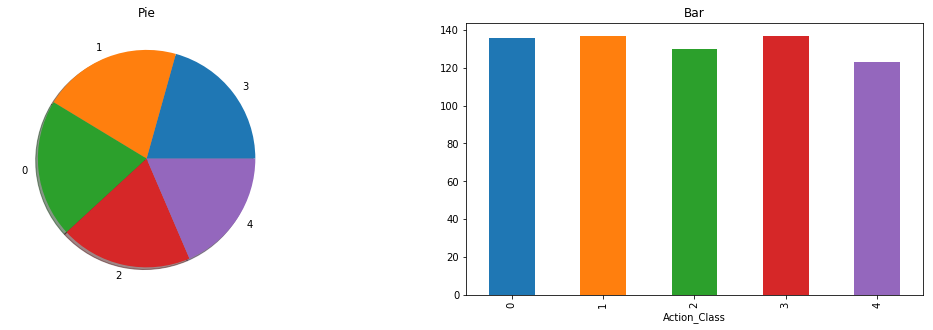

In [23]:
train_df.Action_Class.value_counts()

size = [train_df.Action_Class.value_counts()[0],train_df.Action_Class.value_counts()[1],
        train_df.Action_Class.value_counts()[2],train_df.Action_Class.value_counts()[3],
        train_df.Action_Class.value_counts()[4]]
lables = ['3','1','0','2','4']

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.pie(size,labels=lables,shadow=True)
plt.title('Pie')

plt.subplot(1,2,2)
plt.title('Bar')
train_df.groupby('Action_Class').Action_name.count().plot(kind='bar') #Balanced
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

# Image Crop & Resize : Many technique(open-cv, scipy, skimage) 

In [24]:

#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]  #crop the image
#     resized_image = cv2.imresize(img, (rows,cols)) # resize the image
    resized_image = cv2.resize(img, (rows,cols)) # resize the image
    return resized_image



In [25]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 120
    z = 120
    
    
    
    while True:
        t = np.random.permutation(folder_list)
#         if len(t)%batch_size==0:
        num_batches = int(len(t)//batch_size) # calculate the number of batches
#         else:
#             num_batches = int(len(t)//batch_size + 1)
#             rest_videos_count = int(len(t)%batch_size)
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        
        # write the code for the remaining data points which are left after full batches
        if int(len(t)%batch_size!=0):
            rest_videos_count = int(len(t)%batch_size)
            for folder in range(rest_videos_count): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [26]:
curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
val_path = 'Project_data/val'


num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Bidirectional,LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [28]:
frame = 20
rows = 120
cols = 120
channel_color = 3
num_classes = 5

# <font color = 'blue'> Model 1 : Vanilla Conv3d

In [29]:
model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", activation = "relu" , input_shape = (frame, rows, cols, channel_color)))
model.add(BatchNormalization())

#HL1
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#HL2
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Fully connected
model.add(Flatten())
model.add(Dense(256,  activation = "relu"))

#output layer
model.add(Dense(num_classes, activation = "softmax"))


In [30]:
optimiser = "adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 120, 120, 32)  128       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 20, 120, 120, 64)  55360     
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 120, 120, 64)  256       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 60, 60, 64)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 60, 60, 128)   221312    
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 60, 60, 128)   512       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  67
Val Epoch value:  10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val Source path =  Project_data/train ; batch size = 10
; batch size = 10
Epoch 1/10
67/67 [==============================] - 191s 3s/step - loss: 12.7164 - categorical_accuracy: 0.2104 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 13.21684, saving model to model_init_2020-09-1415_34_58.030609/model-00001-12.71641-0.21045-13.21684-0.18000.h5
Epoch 2/10
67/67 [==============================] - 168s 3s/step - loss: 12.8464 - categorical_accuracy: 0.2030 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 13.21684
Epoch 3/10
67/67 [==============================] - 168s 3s/step - loss: 12.9426 - categorical_accuracy: 0.2060 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 13.21684

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
67/67 [==============================] - 1

In [19]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

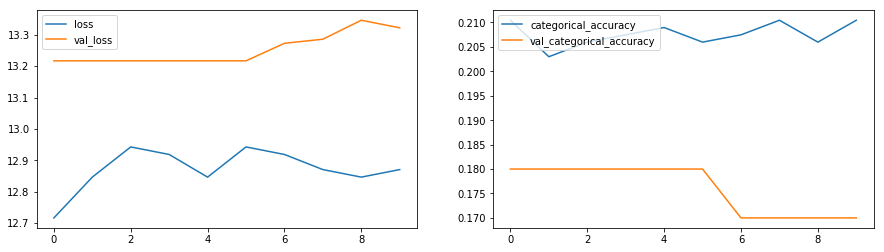

In [20]:
plot(history)

In [26]:
model_detail_df = pd.DataFrame()

In [27]:
def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_detail_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Val Accuracy" : val_accuracy * 100,
                   "Val Loss" : val_loss * 100}

    df = pd.DataFrame([model_detail_dic])
    return df
    

In [28]:
df1 = model_result("Model_1_Vanilla",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss       Model Name  Val Accuracy     Val Loss
0       21.044777  1287.041966  Model_1_Vanilla          17.0  1332.210426


# <font color = 'blue'> Model 3: changing optimizer to "SGD" & Added L2 Regularization

In [14]:
#Let's try 'sgd' as optimizer on same architecture with 10 epochs

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 30, 30, 32)     0         
__________

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
22/67 [========>.....................] - ETA: 3:34 - loss: 12.2790 - categorical_accuracy: 0.2091

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model_3_SGD",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

# <font color = 'blue'> Model 2 : Reducing Filter (2,2,2) & Added Huper Tuning Paramaters

In [23]:
#Let's try reducing the filter 
# Added Batch normalization to each layer
#

model2 = Sequential()


model2.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (20,120,120,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model2.add(Dropout(0.50))



model2.add(Dense(5, activation = 'softmax'))

optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 30, 30, 32)     0         
__________

In [28]:
history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 40s 593ms/step - loss: 18.4878 - categorical_accuracy: 0.2060 - val_loss: 16.1097 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss did not improve from 8.53787
Epoch 2/10
67/67 [==============================] - 36s 542ms/step - loss: 15.2815 - categorical_accuracy: 0.2104 - val_loss: 14.4870 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 8.53787
Epoch 3/10
67/67 [==============================] - 36s 533ms/step - loss: 14.0574 - categorical_accuracy: 0.2134 - val_loss: 13.1881 - val_categorical_accuracy: 0.2400

Epoch 00003: val_loss did not improve from 8.53787
Epoch 4/10
67/67 [==============================] - 36s 540ms/step - loss: 13.7596 - categorical_accuracy: 0.1940 - val_loss: 12.7583 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 8.53787
Epoch 5/10
67/67 [==============================] - 36s 540ms/step - loss: 13.1404 - categorical_accuracy: 0.2149 - 

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model_2_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

# <font color = 'blue'> Model 4 : Added more Hidden Layer

In [25]:
# Adding more layer to the architecture 

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
## h1,2
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h3,4
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())


model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h5,6
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 60, 60, 32)    27680     
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 60, 60, 32)    128       
__________

In [17]:

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 10
Epoch 1/10 Project_data/val ; batch size = 10

67/67 [==============================] - 168s 3s/step - loss: 12.1068 - categorical_accuracy: 0.2537 - val_loss: 9.5518 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 9.55178, saving model to model_init_2020-09-1412_55_21.501249/model-00001-12.10685-0.25373-9.55178-0.25000.h5
Epoch 2/10
67/67 [==============================] - 39s 581ms/step - loss: 6.4202 - categorical_accuracy: 0.4000 - val_loss: 5.9225 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 9.55178 to 5.92254, saving model to model_init_2020-09-1412_55_21.501249/model-00002-6.42019-0.40000-5.92254-0.49000.h5
Epoch 3/10
67/67 [==============================] - 38s 569ms/step - loss: 5.8692 - categorical_accuracy: 0.5060 - val_loss: 6.0159 - val_categorical_accuracy: 0.3600

Epoch 00003: val_loss did not improve from 5.92254
Epoch 4/10
67/67 [=================

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model_2_Add_HL",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

# <font color = 'red'> 2nd Method: CNN + RNN

# <font color = 'blue'> Model 5: CNN + SimpleRNN Network

In [29]:
input_shape = (frame, rows, cols, channel_color)

In [30]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)    18496     
__________

In [31]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 38s 563ms/step - loss: 1.5927 - categorical_accuracy: 0.3716 - val_loss: 1.3914 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from 13.21684 to 1.39136, saving model to model_init_2020-09-1415_34_58.030609/model-00001-1.59269-0.37164-1.39136-0.37000.h5
Epoch 2/10
67/67 [==============================] - 35s 519ms/step - loss: 1.2338 - categorical_accuracy: 0.5179 - val_loss: 1.2658 - val_categorical_accuracy: 0.4700

Epoch 00002: val_loss improved from 1.39136 to 1.26578, saving model to model_init_2020-09-1415_34_58.030609/model-00002-1.23383-0.51791-1.26578-0.47000.h5
Epoch 3/10
67/67 [==============================] - 37s 546ms/step - loss: 1.0155 - categorical_accuracy: 0.5851 - val_loss: 1.1739 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 1.26578 to 1.17394, saving model to model_init_2020-09-1415_34_58.030609/model-00003-1.01552-0.58507-1.17394-0.59000.h5
Epoch 4/10
67/67 [=========

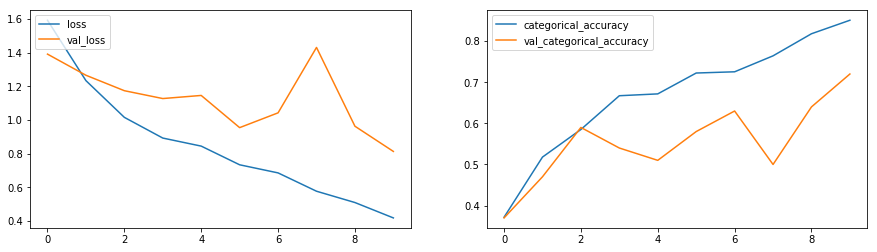

In [32]:
plot(history)

In [34]:
df1 = model_result("Model_5_CNN_RNN",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss             Model Name  Val Accuracy  \
0       21.044777  1287.041966        Model_1_Vanilla          17.0   
0       85.074626    41.789013  Model_5_CNN_SimpleRNN          72.0   
0       85.074626    41.789013        Model_5_CNN_RNN          72.0   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  


In [ ]:
print(model_detail_df.head(20))

# <font color = 'blue'> Model 6: CNN + SimpleRNN Network(Added more cells, Added Dropout in HL)

In [35]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))


model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 30, 30, 64)    0         
__________

In [36]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 39s 588ms/step - loss: 1.5964 - categorical_accuracy: 0.3627 - val_loss: 1.4810 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss did not improve from 0.81305
Epoch 2/10
67/67 [==============================] - 37s 546ms/step - loss: 1.2476 - categorical_accuracy: 0.4731 - val_loss: 1.0363 - val_categorical_accuracy: 0.5300

Epoch 00002: val_loss did not improve from 0.81305
Epoch 3/10
67/67 [==============================] - 37s 547ms/step - loss: 1.0708 - categorical_accuracy: 0.5537 - val_loss: 1.0851 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss did not improve from 0.81305
Epoch 4/10
67/67 [==============================] - 37s 545ms/step - loss: 1.0296 - categorical_accuracy: 0.5851 - val_loss: 1.0461 - val_categorical_accuracy: 0.6100

Epoch 00004: val_loss did not improve from 0.81305

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
67/67 [========================

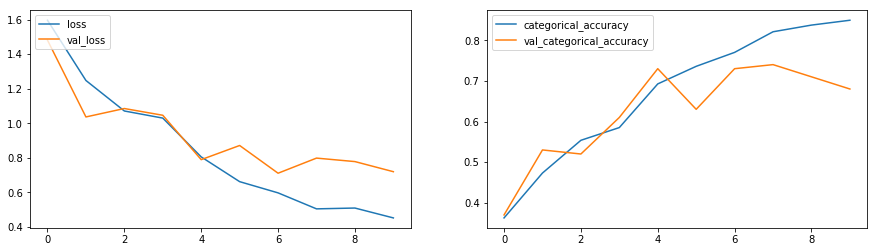

In [37]:
plot(history)

In [38]:
df1 = model_result("Model_6_CNN_RNN_Add_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla          17.0   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN          72.0   
0       85.074626    41.789013             Model_5_CNN_RNN          72.0   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning          68.0   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  


# <font color = 'blue'> Model 7: CNN + LSTM Network()

In [39]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [41]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 38s 564ms/step - loss: 1.4170 - categorical_accuracy: 0.3821 - val_loss: 1.4251 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 35s 528ms/step - loss: 1.1572 - categorical_accuracy: 0.5478 - val_loss: 1.2939 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 35s 526ms/step - loss: 1.1030 - categorical_accuracy: 0.5507 - val_loss: 1.2588 - val_categorical_accuracy: 0.4700

Epoch 00003: val_loss did not improve from 0.71041
Epoch 4/10
67/67 [==============================] - 37s 547ms/step - loss: 1.0135 - categorical_accuracy: 0.6045 - val_loss: 1.2761 - val_categorical_accuracy: 0.5400

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [==============================] - 37s 546ms/step - loss: 0.8708 - categorical_accuracy: 0.6612 - val_loss:

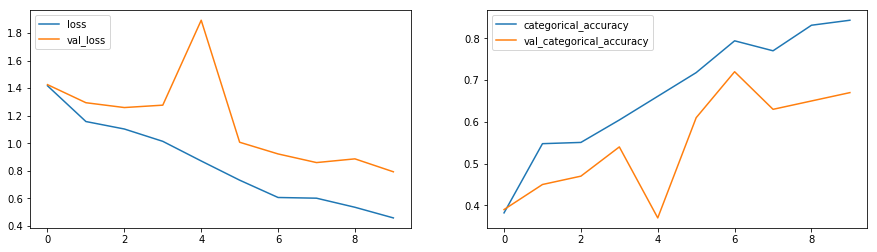

In [42]:
plot(history)

In [43]:
df1 = model_result("Model_7_CNN_LSTM",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla          17.0   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN          72.0   
0       85.074626    41.789013             Model_5_CNN_RNN          72.0   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning          68.0   
0       84.328357    45.736756            Model_7_CNN_LSTM          67.0   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  
0    79.238954  


# <font color = 'blue'> Model 8: CNN + LSTM Network(Added more cells, Removed Hidden Layer, Added Dropout)

In [47]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 30, 30, 64)    0         
__________

In [48]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 71s 1s/step - loss: 1.6412 - categorical_accuracy: 0.2731 - val_loss: 1.6003 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 59s 885ms/step - loss: 1.3174 - categorical_accuracy: 0.4537 - val_loss: 2.0596 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 59s 885ms/step - loss: 1.2307 - categorical_accuracy: 0.5060 - val_loss: 1.5622 - val_categorical_accuracy: 0.4300

Epoch 00003: val_loss did not improve from 0.71041
Epoch 4/10
67/67 [==============================] - 59s 886ms/step - loss: 1.1329 - categorical_accuracy: 0.5313 - val_loss: 1.9120 - val_categorical_accuracy: 0.3300

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [==============================] - 59s 886ms/step - loss: 1.0285 - categorical_accuracy: 0.5687 - val_loss: 1.

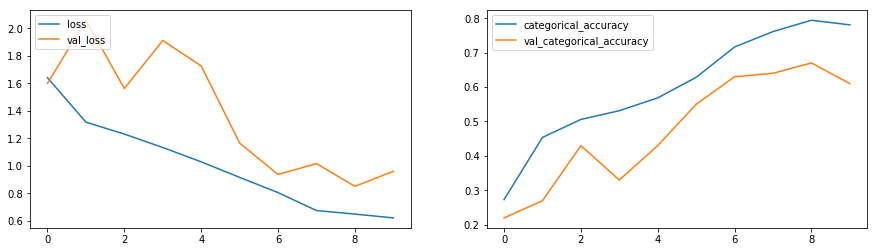

In [49]:
plot(history)

In [50]:
df1 = model_result( "Model_8_CNN_LSTM_Tune", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla     17.000000   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN     72.000000   
0       85.074626    41.789013             Model_5_CNN_RNN     72.000000   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning     68.000000   
0       84.328357    45.736756            Model_7_CNN_LSTM     67.000000   
0       78.059702    62.010612       Model_8_CNN_LSTM_Tune     61.000001   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  
0    79.238954  
0    95.976012  


# <font color = 'blue'> Model 9 : CNN + GRU Network 

In [51]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_59 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_60 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_61 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_62 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_63 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_64 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [52]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 41s 605ms/step - loss: 1.4539 - categorical_accuracy: 0.4015 - val_loss: 1.2004 - val_categorical_accuracy: 0.5700

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 37s 557ms/step - loss: 1.1359 - categorical_accuracy: 0.5537 - val_loss: 1.2232 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 38s 563ms/step - loss: 1.0577 - categorical_accuracy: 0.5851 - val_loss: 1.2969 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss did not improve from 0.71041

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
67/67 [==============================] - 37s 551ms/step - loss: 0.8169 - categorical_accuracy: 0.6881 - val_loss: 0.9588 - val_categorical_accuracy: 0.6800

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [========================

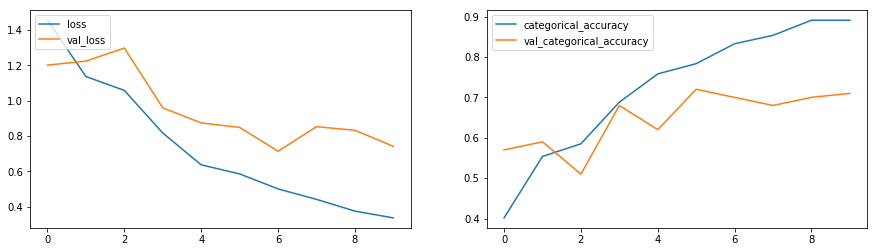

In [53]:
plot(history)

In [54]:
df1 = model_result("Model_9_CNN_GRU", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla     17.000000   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN     72.000000   
0       85.074626    41.789013             Model_5_CNN_RNN     72.000000   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning     68.000000   
0       84.328357    45.736756            Model_7_CNN_LSTM     67.000000   
0       78.059702    62.010612       Model_8_CNN_LSTM_Tune     61.000001   
0       89.104477    33.750303             Model_9_CNN_GRU     71.000000   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  
0    79.238954  
0    95.976012  
0    74.194353  


# <font color = 'blue'> Model 10 : CNN + GRU Network(Added more cells, Added Hidden Layer, Added Dropout)

In [55]:
model = Sequential()

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Flatten()))


model.add(GRU(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_72 (TimeDis (None, 20, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_73 (TimeDis (None, 20, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_74 (TimeDis (None, 20, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 20, 60, 60, 64)    36928     
_________________________________________________________________
time_distributed_76 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_77 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 30, 30, 64)    0         
__________

In [56]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 47s 698ms/step - loss: 1.8162 - categorical_accuracy: 0.2731 - val_loss: 2.2737 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 39s 579ms/step - loss: 1.3765 - categorical_accuracy: 0.4567 - val_loss: 1.9971 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 39s 579ms/step - loss: 1.2313 - categorical_accuracy: 0.4881 - val_loss: 1.5413 - val_categorical_accuracy: 0.4600

Epoch 00003: val_loss did not improve from 0.71041
Epoch 4/10
67/67 [==============================] - 39s 579ms/step - loss: 1.1961 - categorical_accuracy: 0.4955 - val_loss: 1.1912 - val_categorical_accuracy: 0.5100

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [==============================] - 39s 579ms/step - loss: 1.1057 - categorical_accuracy: 0.5642 - val_loss:

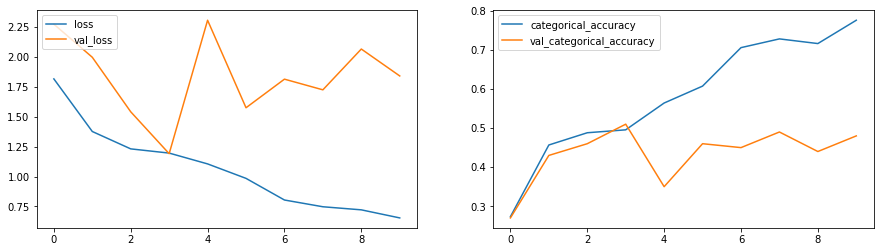

In [57]:
plot(history)

In [58]:
df1 = model_result("Model_10_CNN_GRU_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla     17.000000   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN     72.000000   
0       85.074626    41.789013             Model_5_CNN_RNN     72.000000   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning     68.000000   
0       84.328357    45.736756            Model_7_CNN_LSTM     67.000000   
0       78.059702    62.010612       Model_8_CNN_LSTM_Tune     61.000001   
0       89.104477    33.750303             Model_9_CNN_GRU     71.000000   
0       77.611940    65.411160     Model_10_CNN_GRU_Tuning     48.000001   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  
0    79.238954  
0    95.976012  
0    74.194353  
0   184.093602  


# <font color = 'blue'> Model 11 : conv3d(Added More Neuron, Change Activation : Adam, Added dropout )

In [60]:
#Let's try 'sgd' as optimizer on same architecture with 10 epochs

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(5, activation = 'softmax'))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_31 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_32 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 30, 30, 32)     0         
__________

In [61]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - 40s 603ms/step - loss: 17.0627 - categorical_accuracy: 0.2582 - val_loss: 15.4648 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 36s 537ms/step - loss: 13.4523 - categorical_accuracy: 0.3552 - val_loss: 10.3413 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 37s 554ms/step - loss: 9.8781 - categorical_accuracy: 0.4119 - val_loss: 9.2235 - val_categorical_accuracy: 0.3500

Epoch 00003: val_loss did not improve from 0.71041
Epoch 4/10
67/67 [==============================] - 38s 568ms/step - loss: 8.5439 - categorical_accuracy: 0.4045 - val_loss: 7.4817 - val_categorical_accuracy: 0.3800

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [==============================] - 37s 558ms/step - loss: 7.5866 - categorical_accuracy: 0.4537 - val_l

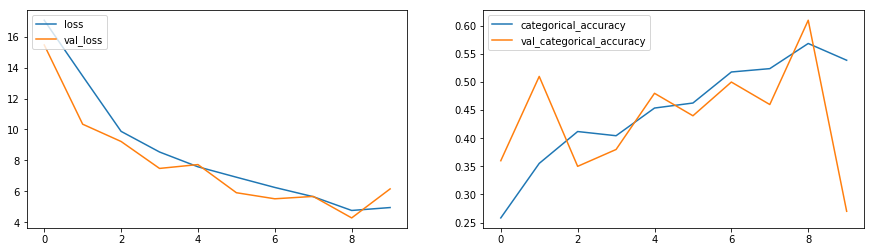

In [62]:
plot(history)

In [63]:
df1 = model_result("Model_11", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

   Model Accuracy   Model Loss                  Model Name  Val Accuracy  \
0       21.044777  1287.041966             Model_1_Vanilla     17.000000   
0       85.074626    41.789013       Model_5_CNN_SimpleRNN     72.000000   
0       85.074626    41.789013             Model_5_CNN_RNN     72.000000   
0       84.925373    45.148897  Model_6_CNN_RNN_Add_Tuning     68.000000   
0       84.328357    45.736756            Model_7_CNN_LSTM     67.000000   
0       78.059702    62.010612       Model_8_CNN_LSTM_Tune     61.000001   
0       89.104477    33.750303             Model_9_CNN_GRU     71.000000   
0       77.611940    65.411160     Model_10_CNN_GRU_Tuning     48.000001   
0       53.880598   495.251317                    Model_11     27.000000   

      Val Loss  
0  1332.210426  
0    81.305320  
0    81.305320  
0    71.925250  
0    79.238954  
0    95.976012  
0    74.194353  
0   184.093602  
0   615.834832  


In [ ]:
# <font color = 'blue'> Model 12 : conv3d(Added More Neuron, Change Activation : Adam, Added dropout, change ba )

In [72]:
#Let's try 'sgd' as optimizer on same architecture with 20 epochs

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_46 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 30, 30, 32)     0         
__________

In [73]:
train_generator = generator(train_path, train_doc, 20)
val_generator = generator(val_path, val_doc, 20)

In [74]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/10
67/67 [==============================] - 81s 1s/step - loss: 13.0475 - categorical_accuracy: 0.4284 - val_loss: 10.8309 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss did not improve from 0.71041
Epoch 2/10
67/67 [==============================] - 74s 1s/step - loss: 10.0718 - categorical_accuracy: 0.6597 - val_loss: 10.0891 - val_categorical_accuracy: 0.6800

Epoch 00002: val_loss did not improve from 0.71041
Epoch 3/10
67/67 [==============================] - 75s 1s/step - loss: 9.6681 - categorical_accuracy: 0.7060 - val_loss: 9.7221 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss did not improve from 0.71041
Epoch 4/10
67/67 [==============================] - 75s 1s/step - loss: 9.2897 - categorical_accuracy: 0.7701 - val_loss: 9.4642 - val_categorical_accuracy: 0.7000

Epoch 00004: val_loss did not improve from 0.71041
Epoch 5/10
67/67 [============

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model_11", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))